In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/steam-reviews/dataset.csv


Dataset: https://www.kaggle.com/datasets/andrewmvd/steam-reviews

In [2]:
# !python -m spacy download en_core_web_md
# !pip install spacy-cleaner

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import re

import spacy
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")
# spacy.require_gpu()

# wordcloud 
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [4]:
data = pd.read_csv("/kaggle/input/steam-reviews/dataset.csv")

## EDA and Visualizations

In [5]:
data.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417106 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 244.8+ MB


In [7]:
data.isnull().sum()

app_id               0
app_name        183234
review_text       7305
review_score         0
review_votes         0
dtype: int64

In [8]:
# first things first remove any duplicates
data.drop_duplicates(inplace=True)

In [9]:
data.shape

(4621004, 5)

In [10]:
# drop reviews that are exactly the same - a rare event
data.drop_duplicates(subset="review_text", inplace=True)

In [11]:
data.shape

(4473474, 5)

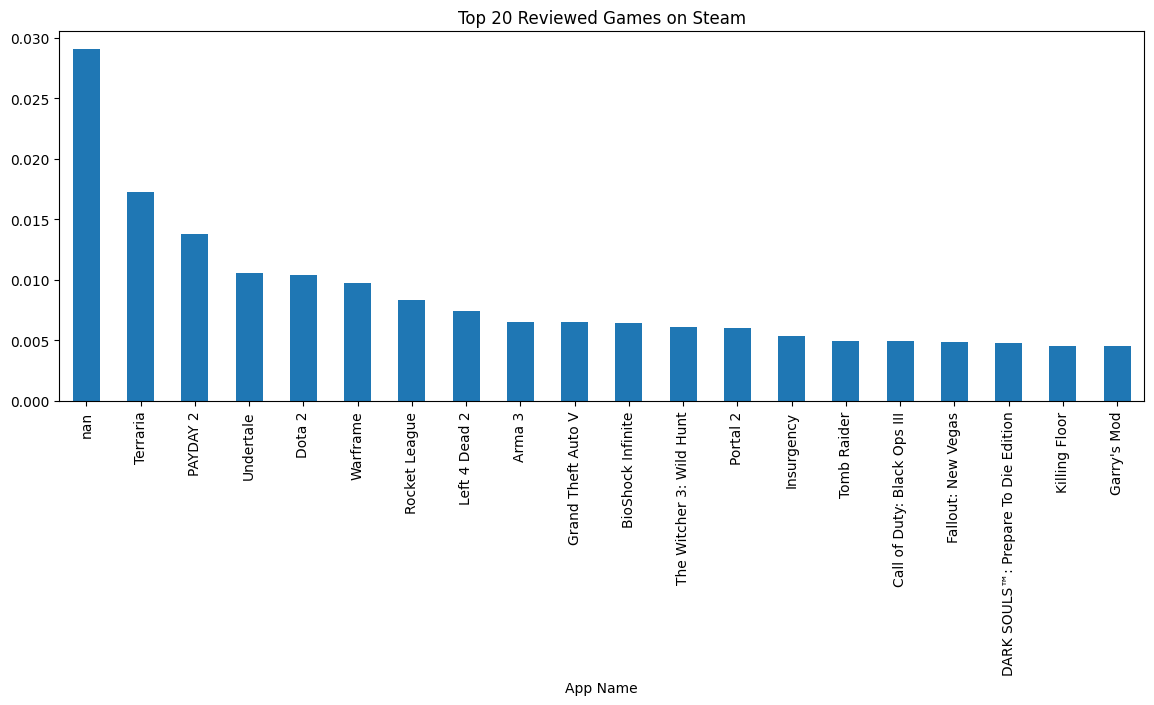

In [12]:
fig = plt.figure()
fig.set_figwidth(14)
data["app_name"].value_counts(normalize=True, dropna=False).head(20).plot(kind="bar")
plt.title("Top 20 Reviewed Games on Steam")
plt.xlabel("App Name")
plt.show()

It looks like there are a large number of reviews without specifying a game. Those will be removed since we cannot use them to gauge any sentiment towards a particular game.

The reviews without any text will also be removed since we cannot understand why a user liked or disliked a game without a written review.

In [13]:
# remove null values
data = data[~data["app_name"].isnull()].copy(deep=True)
data = data[~data["review_text"].isnull()].copy(deep=True)

In [14]:
data.isnull().sum()

app_id          0
app_name        0
review_text     0
review_score    0
review_votes    0
dtype: int64

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4343398 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 198.8+ MB


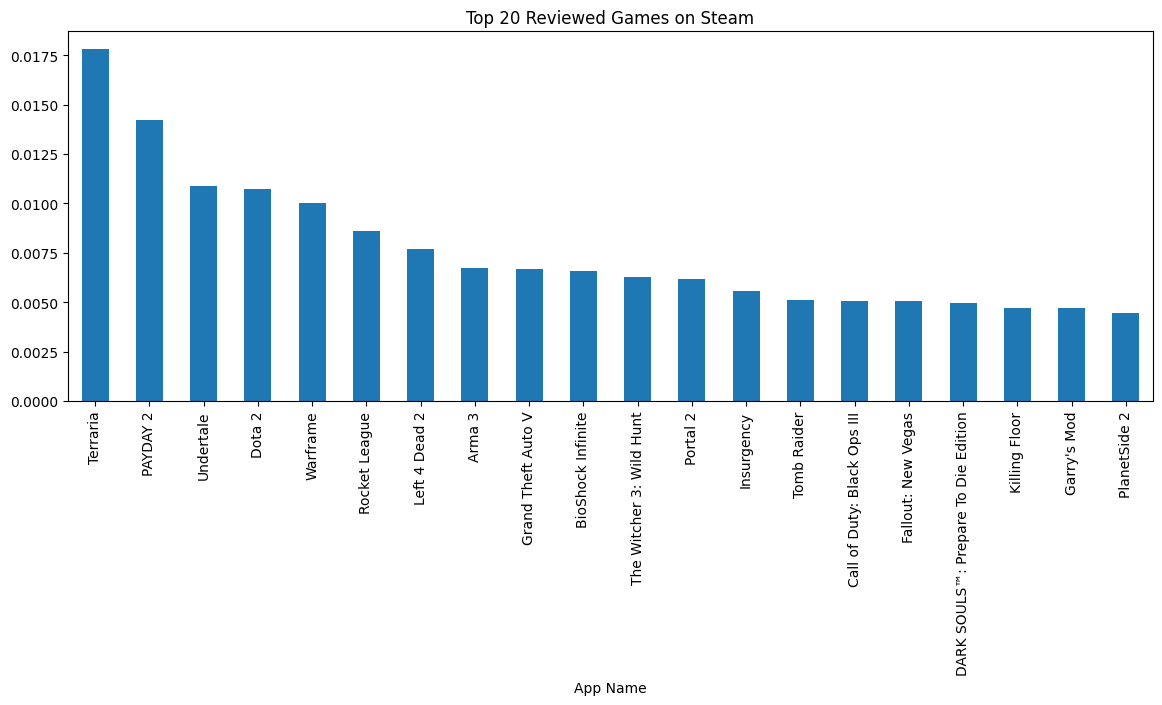

In [16]:
fig = plt.figure()
fig.set_figwidth(14)
data["app_name"].value_counts(normalize=True, dropna=False).head(20).plot(kind="bar")
plt.title("Top 20 Reviewed Games on Steam")
plt.xlabel("App Name")
plt.show()

In [17]:
# how many games are reviewed on steam? a lot
data["app_name"].nunique()

8559

In [18]:
# remove reviews that only say early access review
data = data[(data["review_text"] != " Early Access Review")].copy(deep=True)

In [19]:
# numbers in reviews
data[data["review_text"].isin(["109"])]

,app_id,app_name,review_text,review_score,review_votes
2661386,250900,The Binding of Isaac: Rebirth,109,1,0


In [20]:
data = data[(data["review_text"] != "109")].copy(deep=True)

In [21]:
data["word_count"] = data["review_text"].apply(lambda x: len(x.split()))

data.head()

,app_id,app_name,review_text,review_score,review_votes,word_count
0,10,Counter-Strike,Ruined my life.,1,0,3
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1,449
2,10,Counter-Strike,This game saved my virginity.,1,0,5
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0,47
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1,6


In [22]:
# word count of reviews
data["word_count"].describe()

count    4.343396e+06
mean     6.920050e+01
std      1.188423e+02
min      0.000000e+00
25%      1.200000e+01
50%      2.900000e+01
75%      7.400000e+01
max      4.000000e+03
Name: word_count, dtype: float64

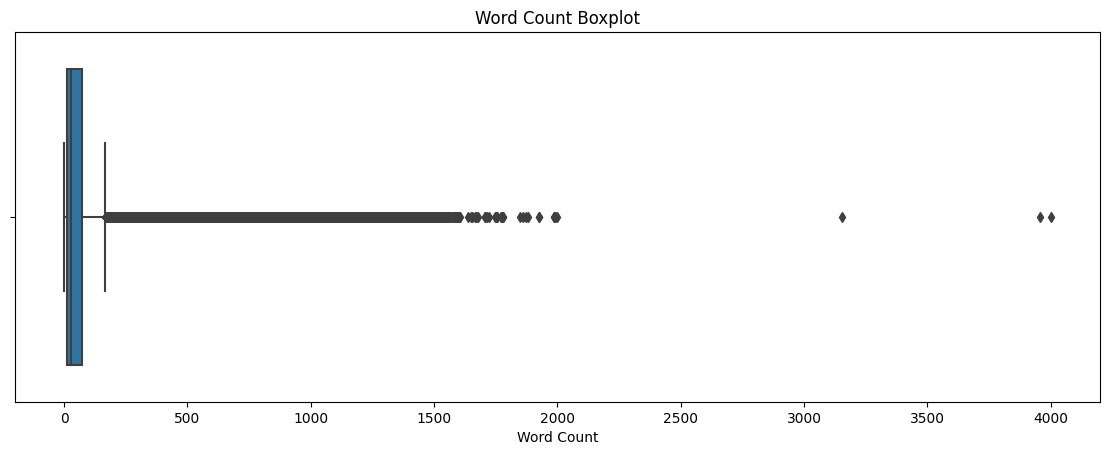

In [23]:
fig = plt.figure()
fig.set_figwidth(14)
sns.boxplot(x=data["word_count"])
plt.title("Word Count Boxplot")
plt.xlabel("Word Count")
plt.show()

In [24]:
# look at some of the longer reviews
data[data["word_count"] > 2000]

,app_id,app_name,review_text,review_score,review_votes,word_count
3456219,282800,100% Orange Juice,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...,1,0,3959
5070537,39000,Moonbase Alpha,! ? ! ? ! ? ! ? ! ? ! ? ! ? ! ? ! ? ! ? ! ? ! ...,1,0,4000
5837142,49520,Borderlands 2,"Nice , Pls Don't Report , HI , HI , HI , HI , ...",1,1,3155


In [25]:
# count words without punctuations
data["count_no_punct"] = data["review_text"].apply(lambda x: len(re.findall(r'\w+', x)))

In [26]:
data.head(10)

,app_id,app_name,review_text,review_score,review_votes,word_count,count_no_punct
0,10,Counter-Strike,Ruined my life.,1,0,3,3
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1,449,468
2,10,Counter-Strike,This game saved my virginity.,1,0,5,5
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0,47,46
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1,6,6
5,10,Counter-Strike,"No r8 revolver, 10/10 will play again.",1,1,7,8
6,10,Counter-Strike,Still better than Call of Duty: Ghosts...,1,1,7,7
7,10,Counter-Strike,"cant buy skins, cases, keys, stickers - gaben ...",1,1,16,16
8,10,Counter-Strike,"Counter-Strike: Ok, after 9 years of unlimited...",1,1,174,181
9,10,Counter-Strike,Every server is spanish or french. I can now f...,1,0,15,16


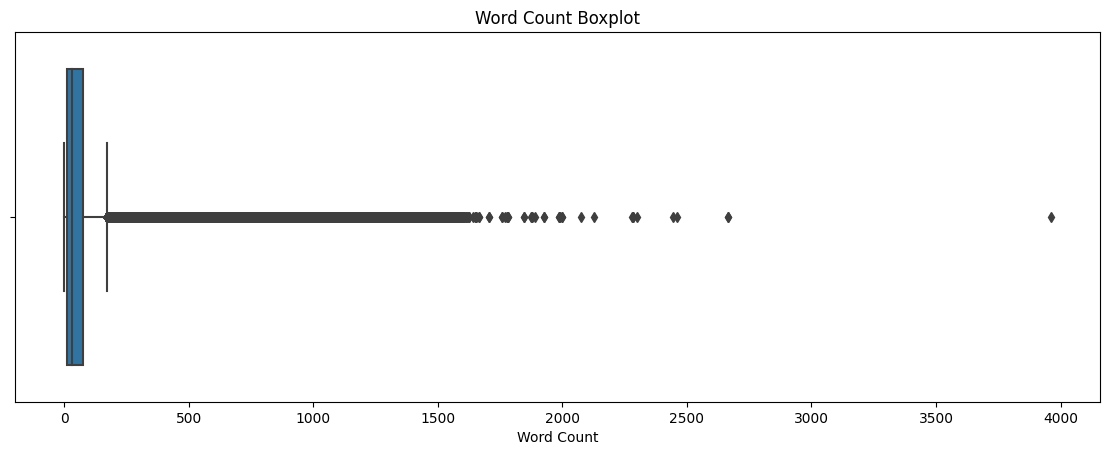

In [27]:
fig = plt.figure()
fig.set_figwidth(14)
sns.boxplot(x=data["count_no_punct"])
plt.title("Word Count Boxplot")
plt.xlabel("Word Count")
plt.show()

In [28]:
# look at some of the longer reviews
data[data["count_no_punct"] > 1500]

,app_id,app_name,review_text,review_score,review_votes,word_count,count_no_punct
22019,10110,Space Quest Collection,I just finished replaying all six of these gam...,1,0,1467,1531
30599,10180,Call of Duty: Modern Warfare 2,CONNECTING TO A NEW HOST. UNABLE TO CONNECT TO...,-1,0,1386,1538
75798,105600,Terraria,This game is so cool so cool so cool so cool s...,1,1,1987,1987
96170,105600,Terraria,DONT LET ME GET INTO MY ZONE DONT LET ME GET I...,1,0,1925,1925
96374,105600,Terraria,I will tickle your pickle I will tickle your p...,1,0,1539,1539
...,...,...,...,...,...,...,...
6342156,8930,Sid Meier's Civilization V,",Bee Movie Script According to all known laws ...",1,1,1476,1505
6368879,9200,RAGE,RAGE is a difficult game for me to recommend o...,-1,0,1452,1505
6372396,92000,Hydrophobia: Prophecy,http://hereberants.wordpress.com/2014/11/10/h...,-1,0,1459,1502
6405535,9900,Star Trek Online,Ok i dont know where to start. and my first st...,1,1,1175,1549


In [29]:
# word count of reviews
data["count_no_punct"].describe()

count    4.343396e+06
mean     7.099508e+01
std      1.218726e+02
min      0.000000e+00
25%      1.300000e+01
50%      3.000000e+01
75%      7.600000e+01
max      3.960000e+03
Name: count_no_punct, dtype: float64

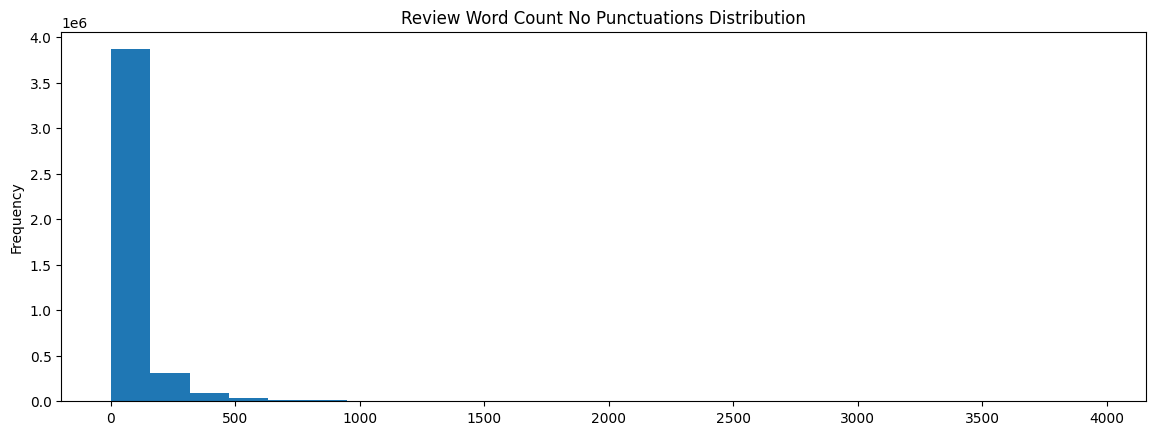

In [30]:
# plot of word count distribution
fig = plt.figure()
fig.set_figwidth(14)
data["count_no_punct"].plot(kind="hist", bins=25)
plt.title("Review Word Count No Punctuations Distribution")
plt.show()

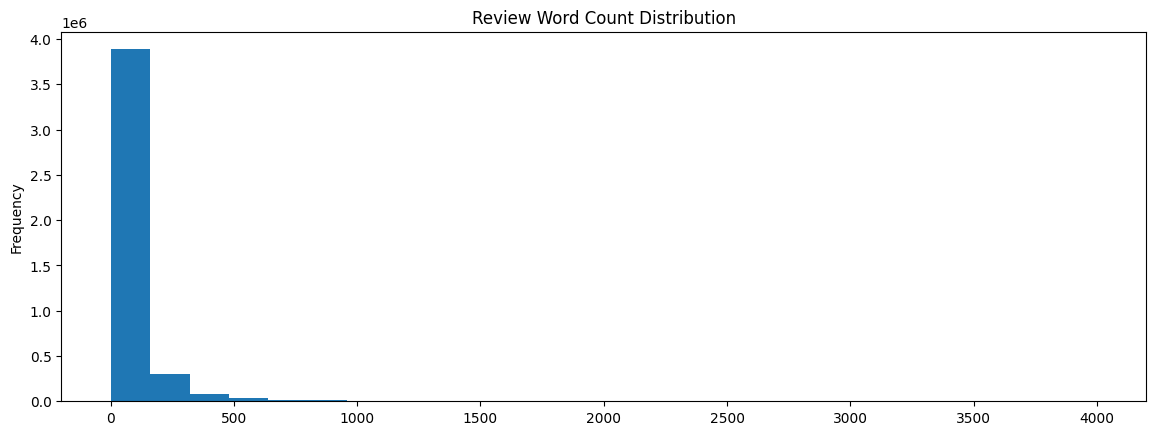

In [31]:
# plot of word count distribution
fig = plt.figure()
fig.set_figwidth(14)
data["word_count"].plot(kind="hist", bins=25)
plt.title("Review Word Count Distribution")
plt.show()

In [32]:
# data.loc[2299925]["review_text"]
# majority of reviews are under 1000 words
# remove reviews that are more than 1000 words
data = data[data["count_no_punct"] < 1001].copy(deep=True)

In [33]:
# reviews that are too short can also be hard to classify
# remove any reviews less than 100 words - since we are taking a subset and this dataset is quite robust
data = data[data["count_no_punct"] > 100].copy(deep=True)

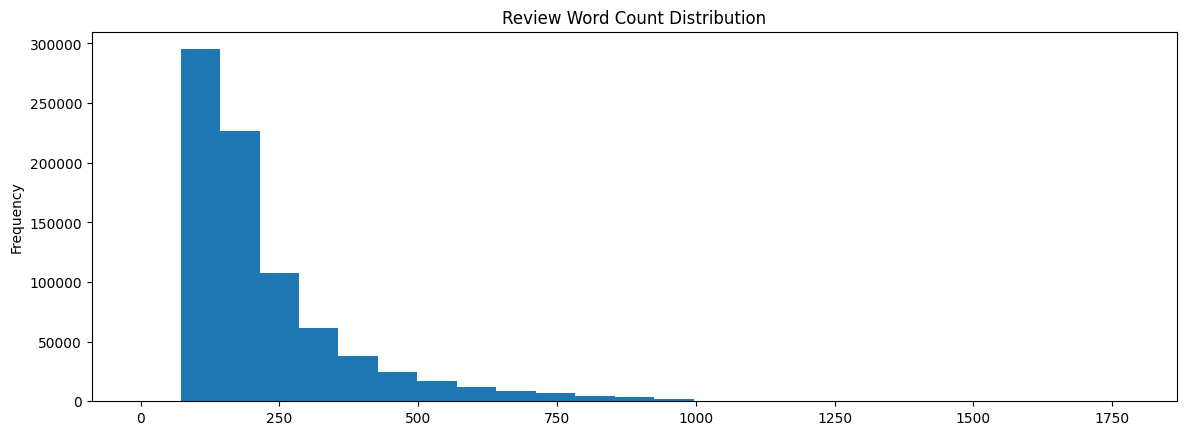

In [34]:
# plot of word count distribution
fig = plt.figure()
fig.set_figwidth(14)
data["word_count"].plot(kind="hist", bins=25)
plt.title("Review Word Count Distribution")
plt.show()

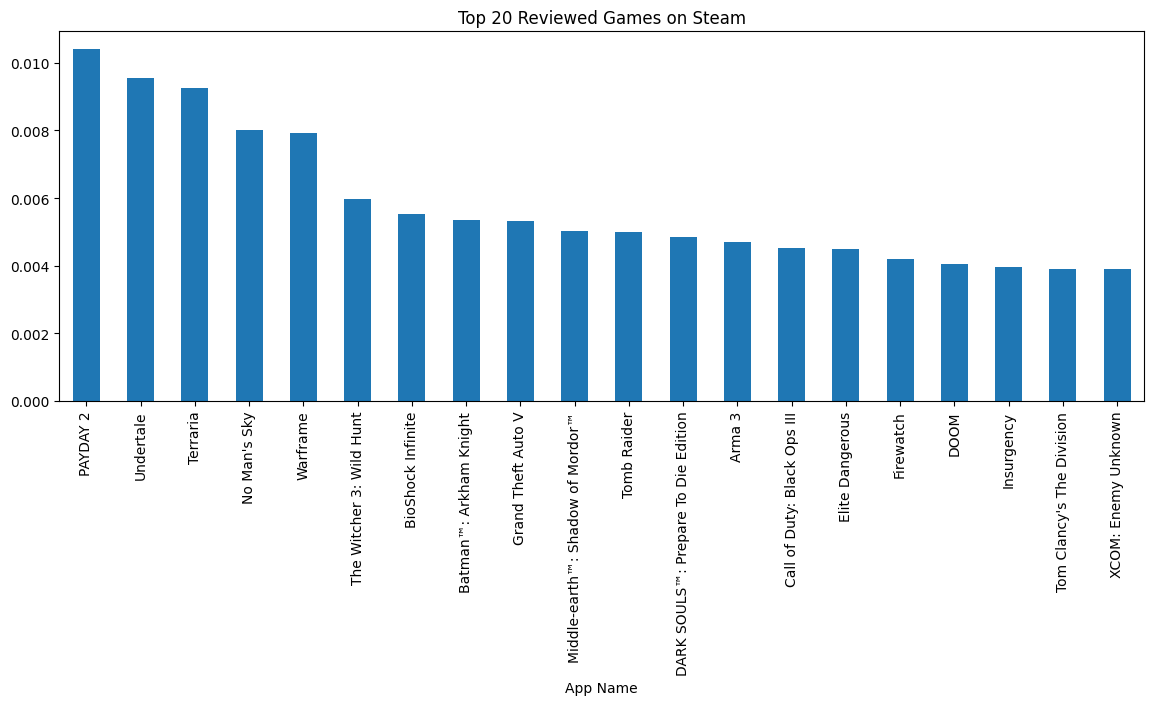

In [35]:
fig = plt.figure()
fig.set_figwidth(14)
data["app_name"].value_counts(normalize=True, dropna=False).head(20).plot(kind="bar")
plt.title("Top 20 Reviewed Games on Steam")
plt.xlabel("App Name")
plt.show()

In [36]:
# convert review scores to 0 and 1
data["review_score"] = data["review_score"].apply(lambda x: 0 if x == -1 else 1)

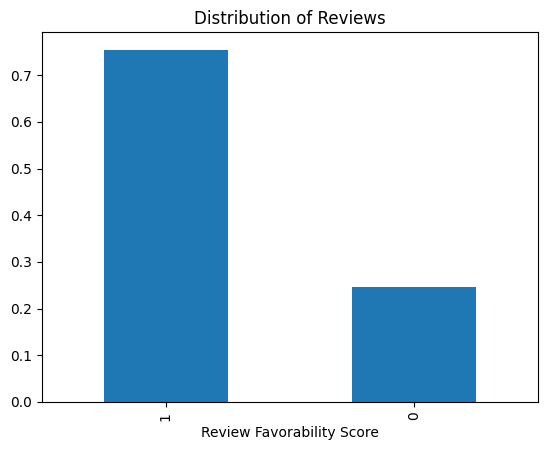

In [37]:
# majority of games are viewed favorably
data["review_score"].value_counts(normalize=True).plot(kind="bar")
plt.title("Distribution of Reviews")
plt.xlabel("Review Favorability Score")
plt.show()

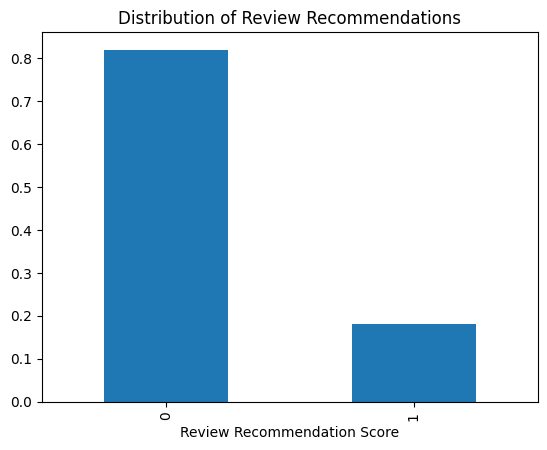

In [38]:
data["review_votes"].value_counts(normalize=True).plot(kind="bar")
plt.title("Distribution of Review Recommendations")
plt.xlabel("Review Recommendation Score")
plt.show()

In [39]:
pd.crosstab(data["review_score"], data["review_votes"])

review_votes,0,1
review_score,,
0,143881,54863
1,518499,91487


In [40]:
# since there are over 9000 games mentioned we will only plot the reviews of the 20 most popular games
game_list = data["app_name"].value_counts(dropna=False).head(20).index.tolist()

game_list

['PAYDAY 2',
 'Undertale',
 'Terraria',
 "No Man's Sky",
 'Warframe',
 'The Witcher 3: Wild Hunt',
 'BioShock Infinite',
 'Batman™: Arkham Knight',
 'Grand Theft Auto V',
 'Middle-earth™: Shadow of Mordor™',
 'Tomb Raider',
 'DARK SOULS™: Prepare To Die Edition',
 'Arma 3',
 'Call of Duty: Black Ops III',
 'Elite Dangerous',
 'Firewatch',
 'DOOM',
 'Insurgency',
 "Tom Clancy's The Division",
 'XCOM: Enemy Unknown']

In [41]:
data_plotted = data[data["app_name"].isin(game_list)].copy(deep=True)

data_plotted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93740 entries, 68092 to 6340586
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   app_id          93740 non-null  int64 
 1   app_name        93740 non-null  object
 2   review_text     93740 non-null  object
 3   review_score    93740 non-null  int64 
 4   review_votes    93740 non-null  int64 
 5   word_count      93740 non-null  int64 
 6   count_no_punct  93740 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 5.7+ MB


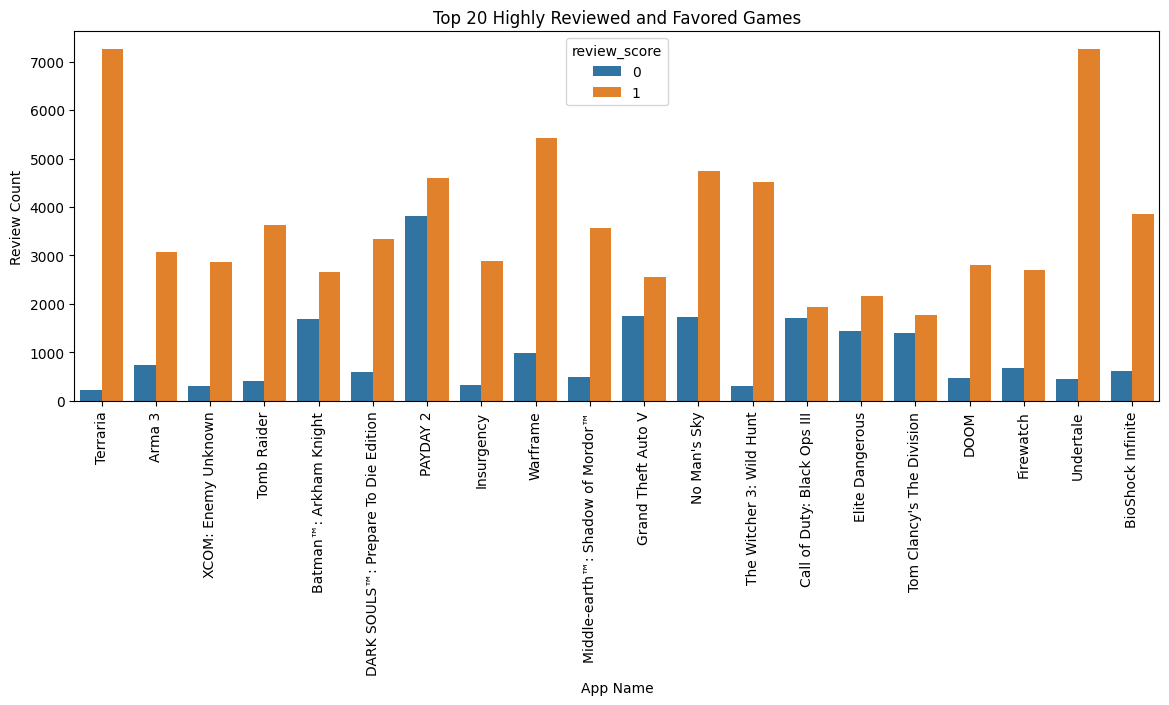

In [42]:
fig = plt.figure()
fig.set_figwidth(14)
sns.countplot(data=data_plotted, x="app_name", hue="review_score")
plt.title("Top 20 Highly Reviewed and Favored Games")
plt.xlabel("App Name")
plt.xticks(rotation=90)
plt.ylabel("Review Count")
plt.show()

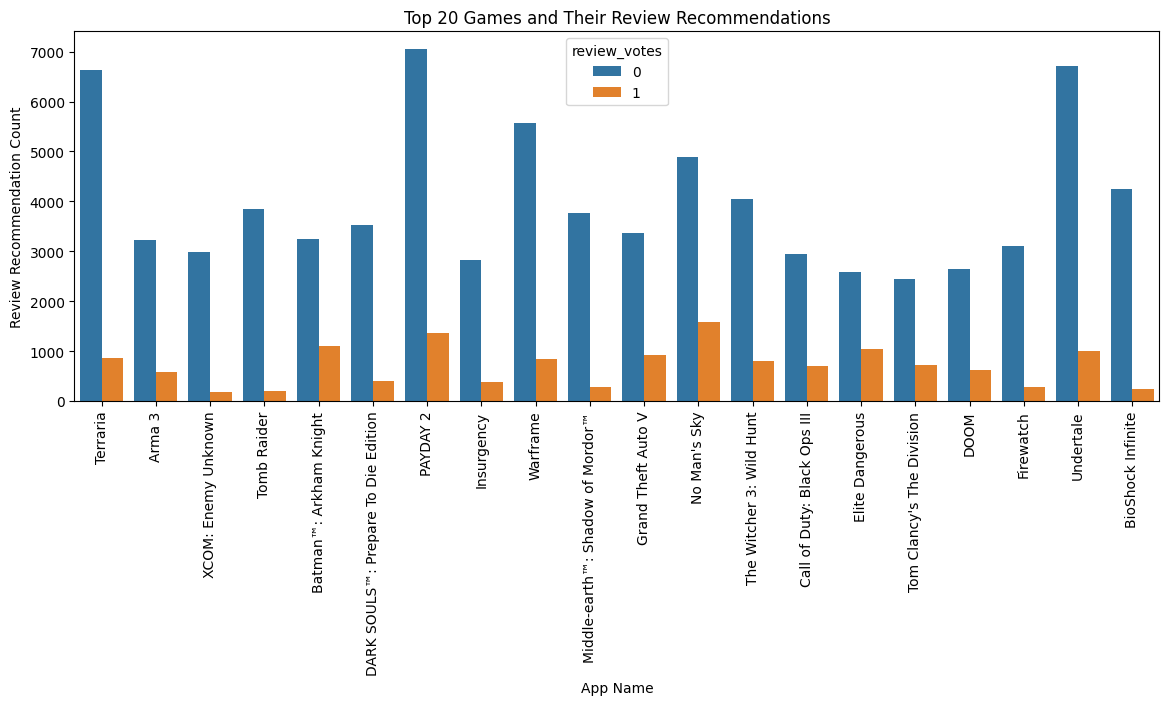

In [43]:
fig = plt.figure()
fig.set_figwidth(14)
sns.countplot(data=data_plotted, x="app_name", hue="review_votes")
plt.title("Top 20 Games and Their Review Recommendations")
plt.xlabel("App Name")
plt.xticks(rotation=90)
plt.ylabel("Review Recommendation Count")
plt.show()

Let's take a look at the least reviewed games on Steam. Since the dataset is already quite large, we can remove any games with less than 300 reviews since having only a small number of reviews makes it harder to establish how the majority of people feel about that game.

In [44]:
# number of games after initial cleaning
data["app_name"].nunique()

8246

In [45]:
# least reviewed games
app_review_count = data["app_name"].value_counts(dropna=False).reset_index()

app_remove_least = app_review_count[app_review_count["count"] < 301]["app_name"].tolist()

In [46]:
# remove games from dataset
data = data[~data["app_name"].isin(app_remove_least)].copy(deep=True)

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 529588 entries, 12428 to 6416149
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   app_id          529588 non-null  int64 
 1   app_name        529588 non-null  object
 2   review_text     529588 non-null  object
 3   review_score    529588 non-null  int64 
 4   review_votes    529588 non-null  int64 
 5   word_count      529588 non-null  int64 
 6   count_no_punct  529588 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 32.3+ MB


After the initial cleaning we're left with about half a million data points, which is still a lot of data. To make the rest of the processing easier, we'll take a subset from our remaining dataset.

Looking at the distribution of positive to negative reviews, there are far more positive than negative reviews. We'll take an even sampling from the positive and negative classes.

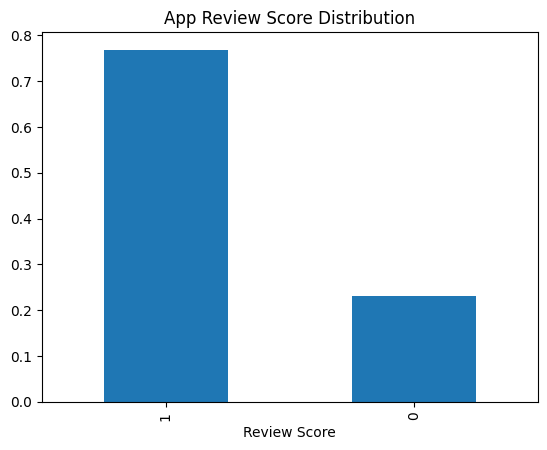

In [48]:
# revisit positive/negative review counts
data["review_score"].value_counts(normalize=True).plot(kind="bar")
plt.title("App Review Score Distribution")
plt.xlabel("Review Score")
plt.show()

In [49]:
# data["review_votes"].value_counts(normalize=True).plot(kind="bar")
# plt.title("App Review Votes")
# plt.xlabel("Review Recommendation Distribution")
# plt.show()

## Taking a Data Subset

In [50]:
# number of positive reviews
data[data["review_score"] == 1].shape

(406966, 7)

In [51]:
# number of negative reviews
data[data["review_score"] == 0].shape

(122622, 7)

In [52]:
# take an even number of samples from each group: positive and negative
positive_rev = data[data["review_score"] == 1].sample(n=15000)
negative_rev = data[data["review_score"] == 0].sample(n=15000)

In [53]:
reviews = pd.concat([positive_rev, negative_rev])

reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 5192579 to 1750946
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   app_id          30000 non-null  int64 
 1   app_name        30000 non-null  object
 2   review_text     30000 non-null  object
 3   review_score    30000 non-null  int64 
 4   review_votes    30000 non-null  int64 
 5   word_count      30000 non-null  int64 
 6   count_no_punct  30000 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.8+ MB


In [54]:
reviews.head()

,app_id,app_name,review_text,review_score,review_votes,word_count,count_no_punct
5192579,394360,Hearts of Iron IV,&gt;Be me &gt;Play as Germany &gt;Jokingly tur...,1,1,185,219
1893188,232430,Gone Home,This game is odd. And when I say that I mean I...,1,0,177,187
3419425,281990,Stellaris,Feels like a (long awaited) Imperium Galactica...,1,0,147,155
2837133,252950,Rocket League,This game is really laggy. Its not my computer...,1,0,141,141
1327385,220780,Thomas Was Alone,This game is amazing. As many many others have...,1,0,108,112


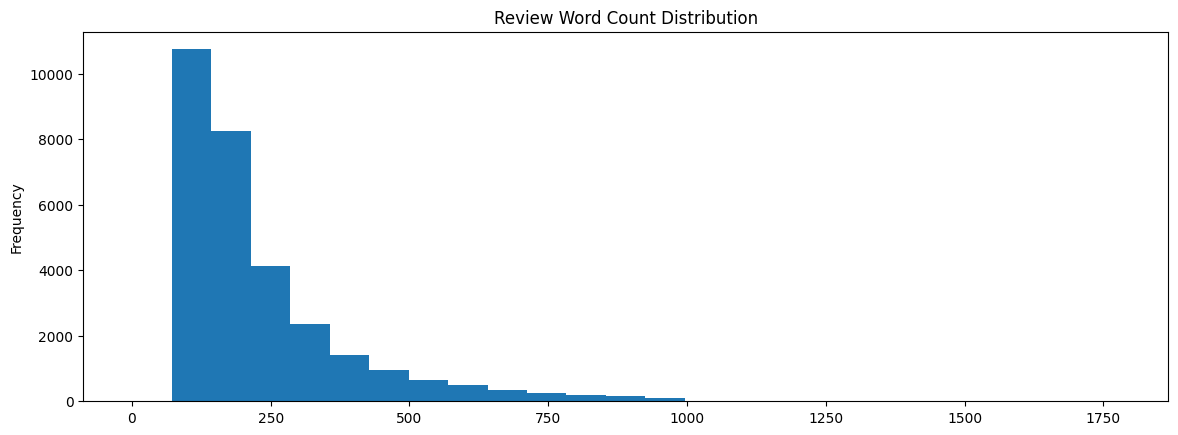

In [55]:
# plot of word count distribution
fig = plt.figure()
fig.set_figwidth(14)
reviews["word_count"].plot(kind="hist", bins=25)
plt.title("Review Word Count Distribution")
plt.show()

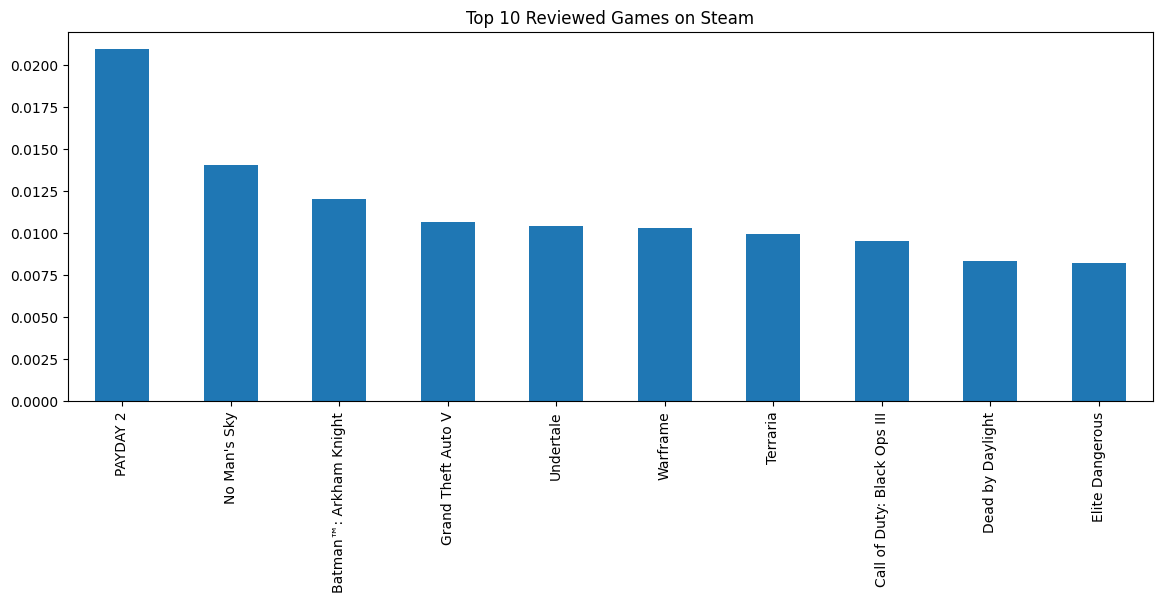

In [56]:
fig = plt.figure()
fig.set_figwidth(14)
reviews["app_name"].value_counts(normalize=True, dropna=False).head(10).plot(kind="bar")
plt.title("Top 10 Reviewed Games on Steam")
plt.xlabel("")
plt.show()

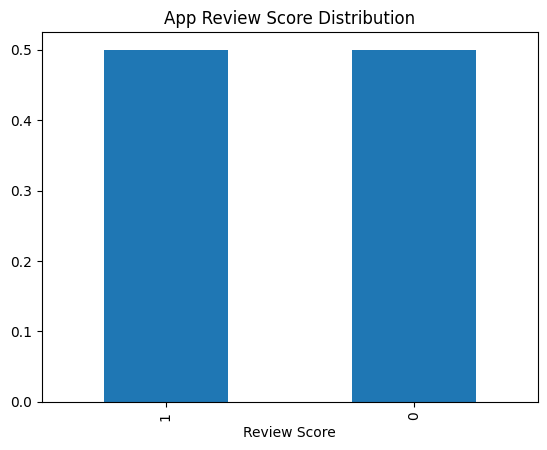

In [57]:
# revisit positive/negative review counts
reviews["review_score"].value_counts(normalize=True).plot(kind="bar")
plt.title("App Review Score Distribution")
plt.xlabel("Review Score")
plt.show()

In [58]:
pd.crosstab(reviews["review_score"], reviews["review_votes"])

review_votes,0,1
review_score,,
0,11163,3837
1,13155,1845


In [59]:
# most popular reviewed games on subset
subset_top = reviews["app_name"].value_counts(dropna=False).head(10).index.tolist()

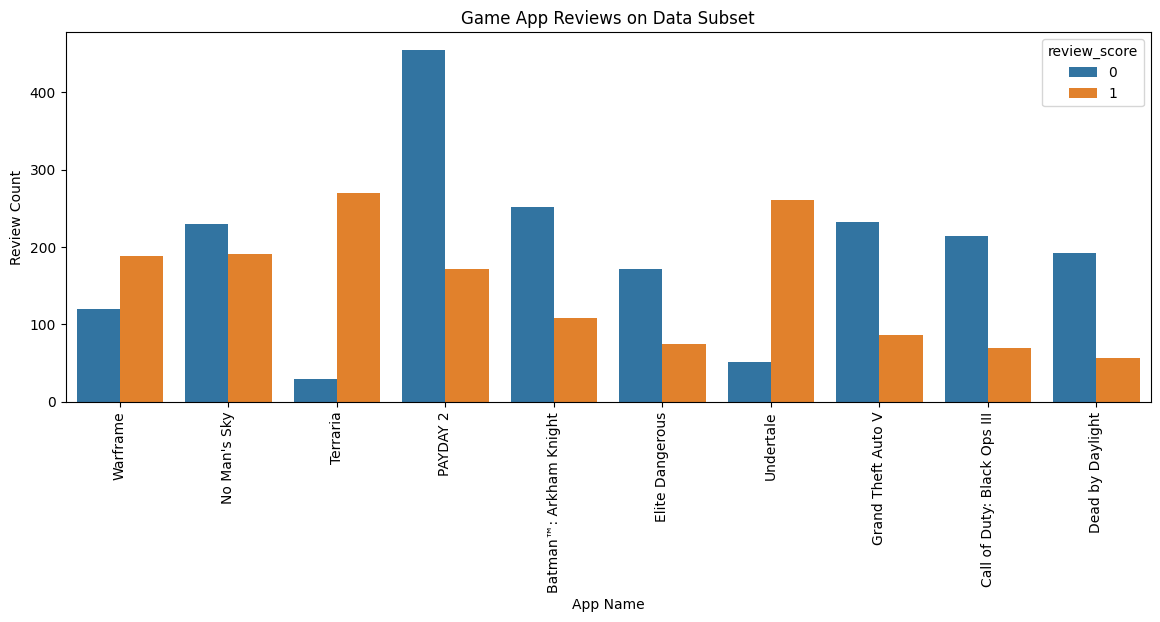

In [60]:
data_subset_top = reviews[reviews["app_name"].isin(subset_top)]

fig = plt.figure()
fig.set_figwidth(14)
sns.countplot(data=data_subset_top, x="app_name", hue="review_score")
plt.title("Game App Reviews on Data Subset")
plt.xlabel("App Name")
plt.xticks(rotation=90)
plt.ylabel("Review Count")
plt.show()

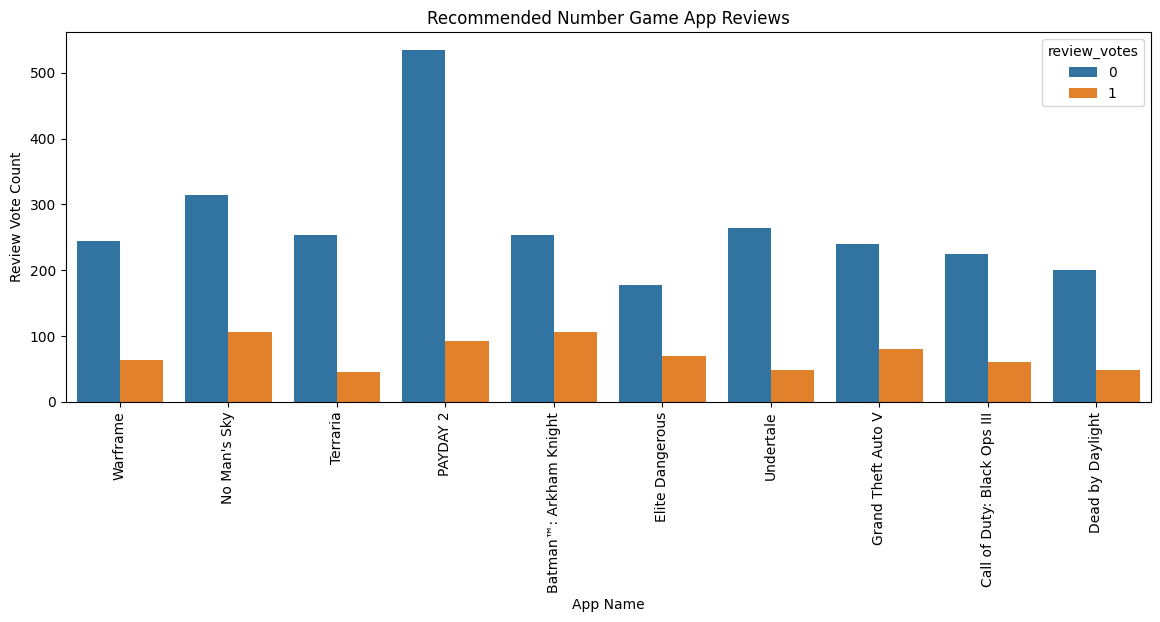

In [61]:
fig = plt.figure()
fig.set_figwidth(14)
sns.countplot(data=data_subset_top, x="app_name", hue="review_votes")
plt.title("Recommended Number Game App Reviews")
plt.xlabel("App Name")
plt.xticks(rotation=90)
plt.ylabel("Review Vote Count")
plt.show()

### Generate WordClouds by Game Top 10

Before we get continue with text processing on our subset, let's go back and take a look at some wordclouds for the top 20 games.

In [62]:
# function to generate wordcloud based on game
def game_wordcloud(game):
    app_df = reviews[reviews["app_name"] == game].copy(deep=True)

    app_review = " ".join(rev for rev in app_df["review_text"])
    
    wordcloud = WordCloud(colormap="tab10_r").generate(app_review)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(game + " App Reviews Wordcloud")
    plt.axis("off")
    plt.show()

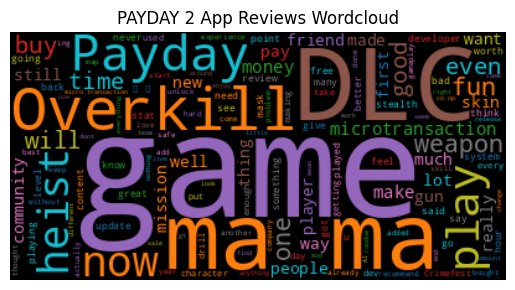

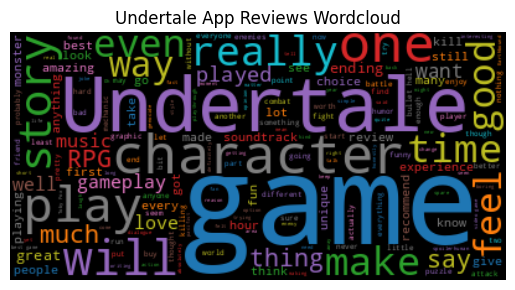

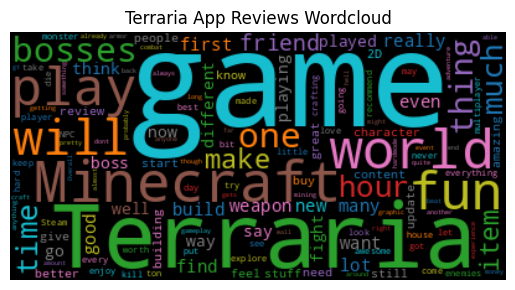

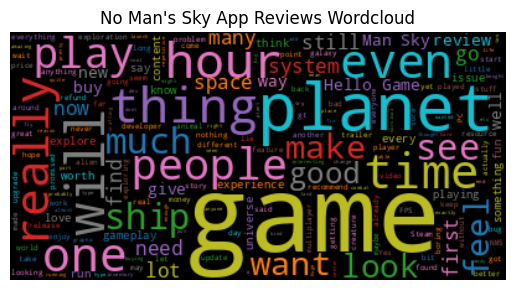

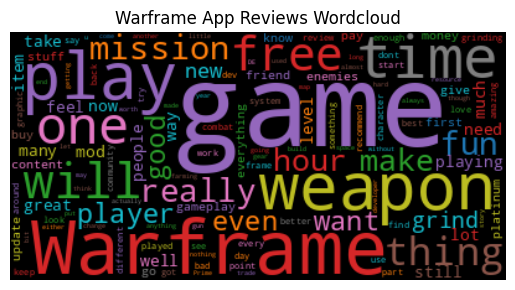

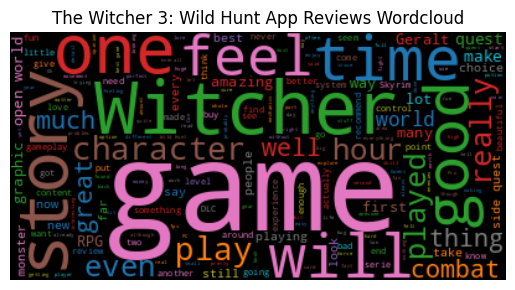

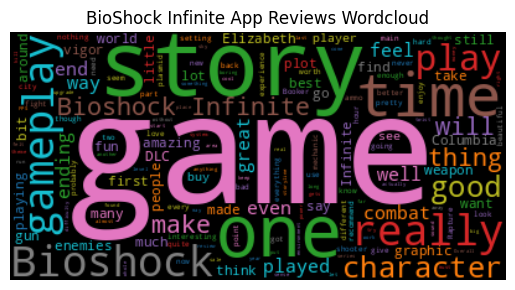

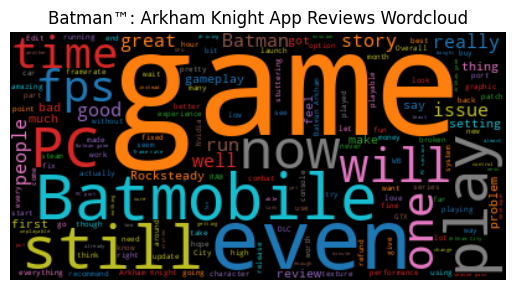

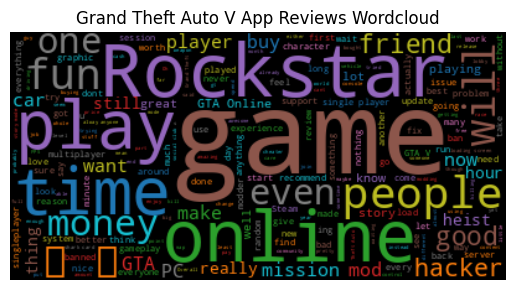

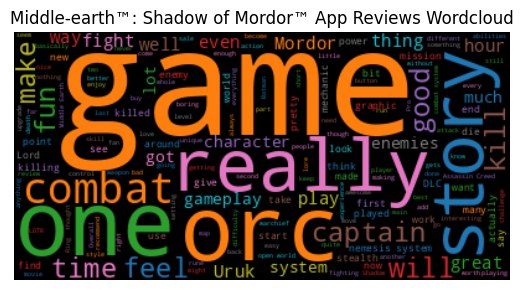

In [63]:
for game in game_list[:10]: 
    game_wordcloud(game)

In [64]:
# check for any reviews that are not string text
# for x in range(len(app_example["review_text"])):
#     if type(app_example["review_text"].iloc[x]) is not str:
#         print(x)

## Data Processing

In [65]:
# remove punctuations stopwords and lemmatize
def remove_stopwords_punct(review):
    review = review.lower()
    app_review = nlp(review)
    filter_stop = [token for token in app_review if not token.is_stop] 
    remove_punc = [token for token in filter_stop if not token.is_punct]
    lemmatize = [token.lemma_ for token in remove_punc]
    app_review = " ".join([token for token in lemmatize])
    
    return app_review

In [66]:
reviews["review_processed"] = reviews["review_text"].apply(lambda x: remove_stopwords_punct(x))

In [67]:
# remove any rows with null reviews
reviews = reviews[~reviews["review_processed"].isnull()].copy(deep=True)

In [68]:
# example review processing
# reviews.loc[874861]["review_text"]

In [69]:
# example review processing
# reviews.loc[874861]["review_processed"]

In [70]:
# split into positive and negative reviews
positive_data = reviews[reviews["review_score"] == 1].copy(deep=True)
negative_data = reviews[reviews["review_score"] != 1].copy(deep=True)

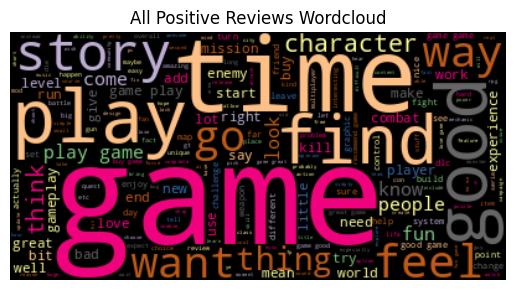

In [71]:
# positive review wordcloud
pos_review = " ".join(rev for rev in positive_data["review_processed"])

wordcloud = WordCloud(background_color="black", colormap="Accent_r").generate(pos_review)

plt.imshow(wordcloud, interpolation='bilinear')
plt.title("All Positive Reviews Wordcloud")
plt.axis("off")
plt.show()

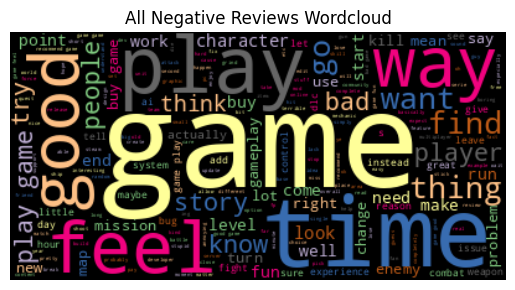

In [72]:
# negative review wordcloud
ne_review = " ".join(rev for rev in negative_data["review_processed"])

wordcloud = WordCloud(background_color="black", colormap="Accent_r").generate(ne_review)

plt.imshow(wordcloud, interpolation='bilinear')
plt.title("All Negative Reviews Wordcloud")
plt.axis("off")
plt.show()

## Data Modeling

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 
from sklearn.decomposition import NMF
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score

In [74]:
# function to show results
def show_metrics(y_test, predictions):
    print("Confusion Matrix: ")
    cmat = metrics.confusion_matrix(y_test, predictions)
    print(cmat)
    print("True Positives (TP) = ", cmat[0,0])
    print("True Negatives (TN) = ", cmat[1,1])
    print("False Positives (FP) = ", cmat[0,1])
    print("False Negatives (FN) = ", cmat[1,0])
    print("Accuracy: ")
    print(metrics.accuracy_score(y_test, predictions))
    print("Precision: ")
    print(metrics.precision_score(y_test, predictions))
    print("F1 Score: ")
    print(metrics.f1_score(y_test, predictions))
    print("Classification Report: ")
    print(metrics.classification_report(y_test, predictions))

In [75]:
reviews.head()

,app_id,app_name,review_text,review_score,review_votes,word_count,count_no_punct,review_processed
5192579,394360,Hearts of Iron IV,&gt;Be me &gt;Play as Germany &gt;Jokingly tur...,1,1,185,219,gt;be gt;play germany gt;jokingly turn histori...
1893188,232430,Gone Home,This game is odd. And when I say that I mean I...,1,0,177,187,game odd mean know exactly describe love story...
3419425,281990,Stellaris,Feels like a (long awaited) Imperium Galactica...,1,0,147,155,feel like long await imperium galactica 2 hege...
2837133,252950,Rocket League,This game is really laggy. Its not my computer...,1,0,141,141,game laggy computer cause ve spend week fix ha...
1327385,220780,Thomas Was Alone,This game is amazing. As many many others have...,1,0,108,112,game amazing say think time interested fate gr...


In [76]:
X = reviews["review_processed"]
y = reviews["review_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

## KMeans

In [77]:
word_vec = TfidfVectorizer() 

train_vector = word_vec.fit_transform(X_train)

train_vector.shape

(24000, 59430)

In [78]:
# reduce the dimensionality of the training dataset - makes it easier to use
pca = PCA(n_components=4) 
reduced_data = pca.fit_transform(train_vector.toarray())

In [79]:
reduced_data.shape

(24000, 4)

In [80]:
# detection of positive or negative review means 2 clusters
num_clusters = 2

kmeans = KMeans(n_clusters=num_clusters, n_init=2, max_iter=500, random_state=42) 
kmeans.fit(train_vector) 

KMeans(max_iter=500, n_clusters=2, n_init=2, random_state=42)

In [81]:
kmeans.labels_

array([0, 0, 1, ..., 0, 1, 0], dtype=int32)

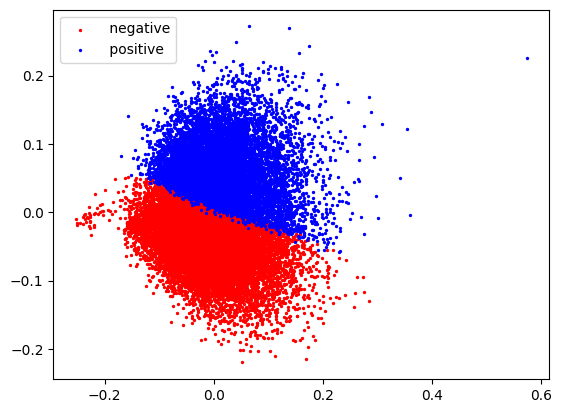

In [82]:
colors = ["red",  "blue"] 
cluster = ["negative", "positive"] 

for i in range(num_clusters): 
    plt.scatter(reduced_data[kmeans.labels_ == i, 0], 
                reduced_data[kmeans.labels_ == i, 1],  
                s=2, color=colors[i],  
                label=f' {cluster[i]}') 
plt.legend() 
plt.show()

In [83]:
silhouette_score(train_vector, kmeans.labels_, random_state=42)

0.0022818304771168433

In [84]:
# clustering results dataframe
results = pd.DataFrame() 
results["review_text"] = X_train
results["cluster"] = kmeans.labels_ 
results["actual_rate"] = y_train

In [85]:
results.head()

,review_text,cluster,actual_rate
2300017,pro lotr movie license good voice act neme...,0,0
239602,binding isaac good fun game place view charact...,0,1
5102729,want play final fantasy 8 computer recommend v...,1,0
3849962,10/10 love concept look game look life try fin...,0,1
2511253,reccomend game slight disgrace early access sy...,1,0


In [86]:
show_metrics(y_train, kmeans.labels_)

Confusion Matrix: 
[[6048 6000]
 [8446 3506]]
True Positives (TP) =  6048
True Negatives (TN) =  3506
False Positives (FP) =  6000
False Negatives (FN) =  8446
Accuracy: 
0.39808333333333334
Precision: 
0.36881969282558386
F1 Score: 
0.32677789169540494
Classification Report: 
              precision    recall  f1-score   support

           0       0.42      0.50      0.46     12048
           1       0.37      0.29      0.33     11952

    accuracy                           0.40     24000
   macro avg       0.39      0.40      0.39     24000
weighted avg       0.39      0.40      0.39     24000



In [87]:
# transform test set
test_vector = word_vec.transform(X_test)

# reduce the dimensionality of the test dataset
test_reduced = pca.transform(test_vector.toarray())

In [88]:
kmeans.predict(test_vector)

array([0, 0, 0, ..., 1, 1, 0], dtype=int32)

In [89]:
show_metrics(y_test, kmeans.predict(test_vector))

Confusion Matrix: 
[[1413 1539]
 [2079  969]]
True Positives (TP) =  1413
True Negatives (TN) =  969
False Positives (FP) =  1539
False Negatives (FN) =  2079
Accuracy: 
0.397
Precision: 
0.38636363636363635
F1 Score: 
0.34881209503239735
Classification Report: 
              precision    recall  f1-score   support

           0       0.40      0.48      0.44      2952
           1       0.39      0.32      0.35      3048

    accuracy                           0.40      6000
   macro avg       0.40      0.40      0.39      6000
weighted avg       0.40      0.40      0.39      6000



In [90]:
# train on PCA dataset
num_clusters = 2

kmeans_pca = KMeans(n_clusters=num_clusters, n_init=2, max_iter=500, random_state=42) 
kmeans_pca.fit(reduced_data) 

KMeans(max_iter=500, n_clusters=2, n_init=2, random_state=42)

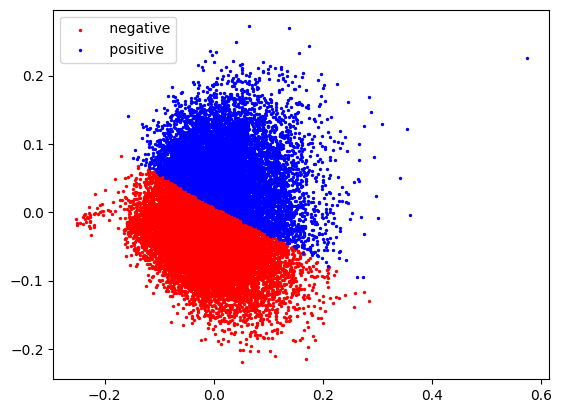

In [91]:
colors = ["red",  "blue"] 
cluster = ["negative", "positive"] 

for i in range(num_clusters): 
    plt.scatter(reduced_data[kmeans_pca.labels_ == i, 0], 
                reduced_data[kmeans_pca.labels_ == i, 1],  
                s=2, color=colors[i],  
                label=f' {cluster[i]}') 
plt.legend() 
plt.show()

In [92]:
silhouette_score(reduced_data, kmeans_pca.labels_, random_state=42)

0.2094067524615899

In [93]:
show_metrics(y_test, kmeans_pca.predict(test_reduced))

Confusion Matrix: 
[[1435 1517]
 [2053  995]]
True Positives (TP) =  1435
True Negatives (TN) =  995
False Positives (FP) =  1517
False Negatives (FN) =  2053
Accuracy: 
0.405
Precision: 
0.3960987261146497
F1 Score: 
0.3579136690647482
Classification Report: 
              precision    recall  f1-score   support

           0       0.41      0.49      0.45      2952
           1       0.40      0.33      0.36      3048

    accuracy                           0.41      6000
   macro avg       0.40      0.41      0.40      6000
weighted avg       0.40      0.41      0.40      6000



## DBSCAN

In [94]:
dbscan = DBSCAN()
dbscan.fit(train_vector)

# dbscan_pred = dbscan.predict(test_vector)

DBSCAN()

In [95]:
# show_metrics(y_test, dbscan_pred)

In [96]:
dbscan.labels_

array([-1, -1, -1, ..., -1, -1, -1])

In [97]:
# dbscan results dataframe
db_results = pd.DataFrame() 
db_results["review_text"] = X_train
db_results["cluster"] = dbscan.labels_
db_results["actual_rate"] = y_train

In [98]:
db_results.head()

,review_text,cluster,actual_rate
2300017,pro lotr movie license good voice act neme...,-1,0
239602,binding isaac good fun game place view charact...,-1,1
5102729,want play final fantasy 8 computer recommend v...,-1,0
3849962,10/10 love concept look game look life try fin...,-1,1
2511253,reccomend game slight disgrace early access sy...,-1,0


In [99]:
# -1 becomes 0 otherwise 1
db_results["convert_cluster"] = np.where(db_results["cluster"] == -1, 0, 1)

In [100]:
db_results.head()

,review_text,cluster,actual_rate,convert_cluster
2300017,pro lotr movie license good voice act neme...,-1,0,0
239602,binding isaac good fun game place view charact...,-1,1,0
5102729,want play final fantasy 8 computer recommend v...,-1,0,0
3849962,10/10 love concept look game look life try fin...,-1,1,0
2511253,reccomend game slight disgrace early access sy...,-1,0,0


In [101]:
db_results["cluster"].value_counts()

cluster
-1    23979
 0       10
 1        6
 2        5
Name: count, dtype: int64

In [102]:
show_metrics(db_results["actual_rate"], db_results["convert_cluster"])

Confusion Matrix: 
[[12039     9]
 [11940    12]]
True Positives (TP) =  12039
True Negatives (TN) =  12
False Positives (FP) =  9
False Negatives (FN) =  11940
Accuracy: 
0.502125
Precision: 
0.5714285714285714
F1 Score: 
0.0020045101478326235
Classification Report: 
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     12048
           1       0.57      0.00      0.00     11952

    accuracy                           0.50     24000
   macro avg       0.54      0.50      0.34     24000
weighted avg       0.54      0.50      0.34     24000



In [103]:
# silhouette_score(db_results["actual_rate"], db_results["convert_cluster"], random_state=42)

## NMF

In [104]:
nmf_tfidf = TfidfVectorizer() 
nmf_preprocess = nmf_tfidf.fit_transform(X)

In [105]:
nmf_preprocess.shape

(30000, 67039)

In [106]:
# applying NMF
model = NMF(n_components=2, init="nndsvda", solver="mu", l1_ratio=0.5, 
            beta_loss="kullback-leibler", random_state=42)
W = model.fit_transform(nmf_preprocess)
H = model.components_

In [107]:
# predictions array
np.argmax(W, axis=1)[:15]

array([0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1])

In [108]:
# nmf results dataframe
nmf_results = pd.DataFrame() 
nmf_results["review_text"] = X
nmf_results["cluster"] = np.argmax(W, axis=1)
nmf_results["actual_rate"] = y

In [109]:
nmf_results

,review_text,cluster,actual_rate
5192579,gt;be gt;play germany gt;jokingly turn histori...,0,1
1893188,game odd mean know exactly describe love story...,1,1
3419425,feel like long await imperium galactica 2 hege...,0,1
2837133,game laggy computer cause ve spend week fix ha...,0,1
1327385,game amazing say think time interested fate gr...,1,1
...,...,...,...
1635972,bluf puzzle game light platforming feel good ...,1,0
5448968,huniecam studio adequate game gameplay lore wi...,0,0
3168898,horriable gameplay economic stiff barley forwa...,0,0
1092676,recommend base game dlc stop microtransaction ...,0,0


In [110]:
silhouette_score(nmf_preprocess, np.argmax(W, axis=1), random_state=42)

0.0025422486380214625

In [111]:
show_metrics(y, np.argmax(W, axis=1))

Confusion Matrix: 
[[10508  4492]
 [ 6859  8141]]
True Positives (TP) =  10508
True Negatives (TN) =  8141
False Positives (FP) =  4492
False Negatives (FN) =  6859
Accuracy: 
0.6216333333333334
Precision: 
0.6444233357080662
F1 Score: 
0.5892230304346253
Classification Report: 
              precision    recall  f1-score   support

           0       0.61      0.70      0.65     15000
           1       0.64      0.54      0.59     15000

    accuracy                           0.62     30000
   macro avg       0.62      0.62      0.62     30000
weighted avg       0.62      0.62      0.62     30000

